In [1]:
import matplotlib.pyplot as plt 

In [2]:
from dlc_practical_prologue import generate_pair_sets

In [3]:
import torch
from torch import nn 
from torch.nn import functional as F
from torch import optim

In [4]:
tr_inp, tr_target, tr_classes, te_inp, te_target, te_classes = generate_pair_sets(1000)

HTTPError: HTTP Error 503: Service Unavailable

In [1121]:
# target is a 1/0 : 1 if <= second, 0 if > second 

In [1122]:
# normalise data 
mean = torch.mean(tr_inp)
std = torch.std(tr_inp)
tr_inp -= mean 
tr_inp /= std
te_inp -= mean 
te_inp /= std

In [1123]:
torch.mean(tr_inp)

tensor(1.8061e-08)

In [1124]:
torch.bincount(tr_target)

tensor([466, 534])

In [1125]:
# maybe fix class imbalance 

## Set model

In [1126]:
# can try diff activation functions but for now using relu 

In [ ]:
# also try dropout layers

In [1140]:
# LeNet based architecture
class LeNet(nn.Module):
    def __init__(self, inp_channels, out_channels, n_hidden=50):
        super().__init__()
        self.conv1 = nn.Conv2d(inp_channels, 32, kernel_size=5)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
       # self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64, n_hidden)
        self.fc2 = nn.Linear(n_hidden, out_channels)
        
    def forward(self, x):
        # CONV LAYER 1 
     #   print('init shape', x.shape)
        x = self.conv1(x)
     #   print('shape after conv1', x.shape)
        x = F.relu(self.pool1(x))
      #  print('shape after pool1', x.shape)
        
        # CONV LAYER 2
        x = self.conv2(x)
      #  print('shape after conv2', x.shape)
    
        x = F.relu(x)
      #  x = F.relu(self.pool2(x))
       # print('shape after pool2', x.shape)
        
        x = x.view(x.size(0), -1)
       # print('shape after reshaping', x.shape)
        
        # FC 1
        x = F.relu(self.fc1(x))
      #  print('shape after fc1', x.shape)
        
        # FC2 
        x = self.fc2(x)
      #  print('shape after fc2', x.shape)
        return x

In [1275]:
def train_model(model, criterion, 
               tr_inp, tr_target, mini_batch_size,
               optimizer, nb_epochs, verbose=False):
    losses = torch.zeros(nb_epochs)
    train_accuracy = torch.zeros(nb_epochs)
    
    for i, e in enumerate(range(nb_epochs)):
        loss_epoch = 0 
        correct_epoch = 0
        for b in range(0, tr_inp.size(0), mini_batch_size):
            tr_inp_chunk = tr_inp.narrow(0, b, mini_batch_size)
            tr_target_chunk = tr_target.narrow(0, b, mini_batch_size)
            output = model(tr_inp_chunk)
            loss = criterion(output, tr_target_chunk)
            loss_epoch += loss.item()
            
            with torch.no_grad():
                pred = model(tr_inp_chunk)
                label = torch.argmax(pred, dim=1)
                true_label = tr_target_chunk
                correct_epoch += (label == true_label).sum().item()

            model.zero_grad()
            loss.backward()
            optimizer.step()
        
        train_accuracy[i] = correct_epoch / tr_target.size(0)
        losses[i] = loss_epoch                                         

        if verbose:
            print('epoch', e)
            print('loss', loss_epoch)

    return model, losses, train_accuracy

In [1276]:
def compute_class_accuracy(model, te_inp, te_target, mini_batch_size):
    incorrect = 0
    
    for b in range(0, te_inp.size(0), mini_batch_size):
        pred = model(te_inp.narrow(0, b, mini_batch_size))
        label = torch.argmax(pred, dim=1)
       # print('predicted labels', label)
        true_label = te_target.narrow(0, b, mini_batch_size)
       # print('true labels', true_label)
        
        incorrect += torch.count_nonzero(true_label - label)

    acc = 1 - incorrect / te_target.size(0) 
    return acc

## Set params

In [1277]:
criterion = nn.CrossEntropyLoss()

In [1301]:
mini_batch_size = 100

In [1302]:
nb_epochs = 25

In [1357]:
eta = 1e-2

In [1358]:
inp_channels = 2
out_class_channels = 2 
out_digit_channels = 10 

# Initially predict 0/1

In [1359]:
model = LeNet(inp_channels=inp_channels, out_channels=out_class_channels)

In [1360]:
optimizer = optim.Adam(model.parameters(), lr=eta)

In [1361]:
# mess around with optimiser params
# also try decaying learning rate

In [1362]:
model, losses, tr_acc = train_model(model, criterion, tr_inp, tr_target,
                    mini_batch_size, optimizer, nb_epochs)

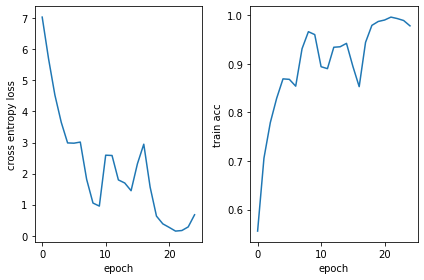

In [1363]:
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].plot(list(range(len(losses))), losses)
ax[0].set_xlabel("epoch")
ax[0].set_ylabel("cross entropy loss")
ax[1].plot(list(range(len(losses))), tr_acc)
ax[1].set_xlabel('epoch')
ax[1].set_ylabel("train acc")
plt.tight_layout()
plt.show()

In [1364]:
te_acc = compute_class_accuracy(model, te_inp, te_target, mini_batch_size)

In [1365]:
te_acc

tensor(0.8090)